In [1]:
def make_submission(X_test, net, fname="my_submission.csv"):
    with open(fname,'w') as fout:
        fout.write('Id,Category')
        for i in range(X_test.shape[0]):
            y_h = net.forward(X_test[i])
            y = np.argmax(y_h)
            fout.write("\n{},{}".format(i, int(y)))

In [2]:
# внимание, тут Y_test в обычном формате(не onehot)
def compute_acc(X_test, Y_test, net):
    acc = 0.0
    for i in range(X_test.shape[0]):
        y_h = net.forward(X_test[i])
        y = np.argmax(y_h)
        if(y == Y_test[i]):
            acc += 1.0
    return acc / Y_test.shape[0]

## Подготовка данных

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

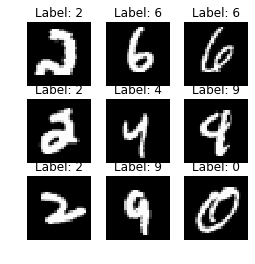

In [4]:
# класс one-hot encoder'а для MNIST

class OneHotEncoder:
    def __init__(self):
        self.transform_mapping = np.zeros((10,10))
        for i in range(self.transform_mapping.shape[0]):
            self.transform_mapping[i][i] = 1.0
        #np.identity(n, dtype=None)[source]
    def transform(self, y):
        return self.transform_mapping[int(y)]

train_data = None
test_data = None

encoder = OneHotEncoder()
with open('data_train.pickle','rb') as fin:
    train_data = pickle.load(fin)
with open('data_test_no_labels.pickle','rb') as fin:
    test_data = pickle.load(fin)

X_train = train_data['data']
Y_train = train_data['target']
Y_train_ohe = np.array(list(map(lambda x : encoder.transform(x), Y_train)))

# X_valid = test_data['data']

# Нормируем признаки [0, 1]
# X_train = X_train.astype('float')
# X_train = (X_train / 255) # - 0.5

#Посмотрим на несколько цифр
n=3
plt.figure(figsize=[4,4])
for i in range(n*n):
    plt.subplot(n,n,i+1)
    i = np.random.randint(0, len(X_train))
    plt.title("Label: %i"%Y_train[i])
    I = X_train[i].reshape((28, 28))
    plt.axis('off')
    plt.imshow(I, cmap='gray')

In [5]:
# Определение слоев сети
class Dense(object):
    def __init__(self, in_size, out_size, rlambda=0.01): #
        self.weights = np.random.normal(scale=1, size=(out_size, in_size)) * \
                            np.sqrt(2 / (out_size + in_size))
        self.bias = np.zeros(out_size)
        self.rlambda = rlambda # regularization parameter
    
    def get_reg_loss(self):
        return 0.5 * self.rlambda * (np.linalg.norm(self.weights, ord='fro') ** 2)
  
    def forward(self, x):
        self.x = x  # запоминаем для обратного прохода
        return np.dot(self.weights, x) + self.bias
    
    def backward(self, dz, lr=0.005):
        """Update weights and biases using backpropagation"""
        
        self.dw = np.outer(dz, self.x) 
        self.db = dz 
    
        self.dx = np.matmul(dz, self.weights)
#         self.dx = np.matmul(self.weights.T, dz) # output column vector
        if self.rlambda != 0:
            self.dw += self.rlambda * self.weights
        
        #Update weights
        self.weights -= lr * self.dw
        self.bias -= lr * self.db
        # Возвращаем dx для продолжения алгоритма
        return self.dx
    

In [6]:
class Softmax(object): 
    """Vanilla Softmax layer for Neural Network"""
    
    def forward(self, x):
        """"x is activitation vector from L layer 
        C used to prevent exponents explosion """  
#         self.x = x
#         C = - np.max(x)
#         self.exps = np.exp(x + C)
#         self.exps = np.exp(x - np.max(x))
        exps = np.exp(x - np.max(x))
        self.sm = exps / np.sum(exps)
        return self.sm
        
    
    def backward(self, dz):
        self.lp = (np.eye(self.sm.shape[0]) - self.sm).T
        self.lp2 = self.sm * self.lp
        return np.dot(dz,self.lp2) #

In [7]:
class CrossEntropy(object):

    def forward(self, y_true, y_hat):
        self.y_true = y_true
        self.y_hat = y_hat
        assert (y_true.shape == y_hat.shape), 'Wrond dim for y_hat or y_true'
        return -np.sum( y_true * np.log(y_hat + 1e-9))
       
    def backward(self, dz): #, lr=0.001):
        assert((self.y_hat + 1e-8).all() != 0),"Zero divison"
        return (- self.y_true / (self.y_hat)) * dz

In [8]:
class ReLU(object):
    def forward(self, x):
        self.x = x    
        #return max(0, X)
        return np.maximum(0, x)
    
    def backward(self, dz):
        dz[self.x < 0] = 0
        return dz

In [9]:
# Опеределение сети
class MnistNet(object):
    def __init__(self, rlambda=0.0001):
        self.d1 = Dense(784, 200, rlambda) 
        self.a1 = ReLU()
        self.d2 = Dense(200, 30, rlambda)
        self.a2 = ReLU()
#         self.d3 = Dense(30, 16, rlambda)
#         self.a3 = ReLU()
        self.d4 = Dense(30, 10, rlambda)
#         self.a4 = ReLU()
        self.sm = Softmax()
    
    def forward(self, x):
        net = self.d1.forward(x)
        net = self.a1.forward(net)
        net = self.d2.forward(net)
        net = self.a2.forward(net)
#         net = self.d3.forward(net)
#         net = self.a3.forward(net)
        net = self.d4.forward(net)
#         net = self.a4.forward(net)
        net = self.sm.forward(net)
        return net
    
    def backward(self, dz, lr=0.01):
        dz = self.sm.backward(dz)
#         dz = self.a4.backward(dz)
        dz = self.d4.backward(dz, lr)
#         dz = self.a3.backward(dz)
#         dz = self.d3.backward(dz, lr)
        dz = self.a2.backward(dz)
        dz = self.d2.backward(dz, lr)
        dz = self.a1.backward(dz)
        dz = self.d1.backward(dz, lr)
        return dz

In [10]:
from sklearn.model_selection import train_test_split
import tqdm

#Делим на обучающую и тестовую выборки
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, \
                                                    test_size=0.25, stratify=Y_train)

# Центрируем и нормируем признаки
X_train= X_train.astype('float')
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
X_train = (X_train - mean) / (std + 1e-4)
X_test = (X_test - mean) / (std + 1e-4)

Y_train = np.array(list(map(lambda x : encoder.transform(x), Y_train)))
Y_test_ohe = np.array(list(map(lambda x : encoder.transform(x), Y_test)))

In [11]:
#Определяем сеть
net = MnistNet(rlambda=0.001)
loss = CrossEntropy()
lr = 0.001
epochs = 80

In [ ]:
#Процедура обучения
L_train = []
L_test = []
acc = []
for iter in tqdm.tqdm_notebook(range(epochs)):
    lr = 1 / (iter ** 0.6 + 500)
    L_acc = 0.
    L_test_acc = 0.
    
    # Shuffle data
    sh_ind = list(range(X_train.shape[0]))
    np.random.shuffle(sh_ind)
    
    for ind in sh_ind:
        x = X_train[ind]
        y = Y_train[ind] 
        y_hat = net.forward(x)
        L = loss.forward(y, y_hat) # + net.get_reg_loss()
        L_acc += L # sum loss for all training exaples
        dz = loss.backward(1)
        dz = net.backward(dz, lr)
    
    L_acc /= Y_train.shape[0] # X_train.shape[0] ?
    L_train.append(L_acc)
    
    for i in range(X_test.shape[0]):
        x = X_test[i]
        y = Y_test_ohe[i] #ohe 
        y_h = net.forward(x)
        L = loss.forward(y, y_h) # + net.get_reg_loss()
        L_test_acc += L
    L_test_acc /= Y_test.shape[0]
    L_test.append(L_test_acc)
#     Y = np.array(list(map(lambda x : np.argmax(x), Y_train))) # get not ohe
    acc.append(compute_acc(X_test, Y_test, net))
    if iter % 15 == 0:
        print(f"{iter} epoch. Train : {L_acc} . Test : {L_test_acc}. Accuracy: {acc[-1]}")
  


0 epoch. Train : 0.3047890992877938 . Test : 0.21465641896692825. Accuracy: 0.9461333333333334
3 epoch. Train : 0.0646960909088491 . Test : 0.15136453941943212. Accuracy: 0.9651809523809524
6 epoch. Train : 0.03239929864060591 . Test : 0.13971456644522243. Accuracy: 0.9663238095238095
9 epoch. Train : 0.02430250013497112 . Test : 0.13193171569033404. Accuracy: 0.969447619047619
12 epoch. Train : 0.01832489399600645 . Test : 0.12227775782938691. Accuracy: 0.9715809523809524
15 epoch. Train : 0.015097803965232127 . Test : 0.11585721478975645. Accuracy: 0.9740190476190477
18 epoch. Train : 0.020401667043969805 . Test : 0.11815726470952248. Accuracy: 0.9720380952380953
21 epoch. Train : 0.02407166148198083 . Test : 0.12909089212206742. Accuracy: 0.9721142857142857
24 epoch. Train : 0.01827680519412666 . Test : 0.11434171340809685. Accuracy: 0.9740190476190477


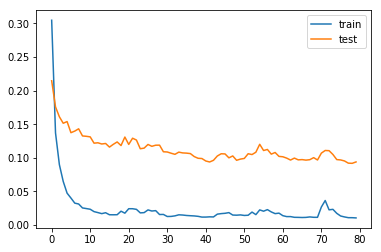

In [14]:
# Здесь необходимо отрисовать графики CrossEntropyLoss для обучающей и валидационной выборок
plt.plot(L_train, label='train')
plt.plot(L_test, label='test')
plt.legend()

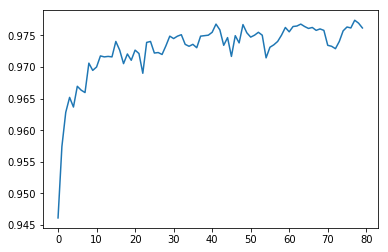

In [15]:
plt.plot(acc)

In [ ]:
#Используем всю выборку для обучения
X_train = train_data['data']
Y_train = train_data['target']

# X_train = X_train / 255

X_train= X_train.astype('float')
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
X_train = (X_train - mean) / (std + 1e-8)

Y_train_ohe = np.array(list(map(lambda x : encoder.transform(x), Y_train)))

In [ ]:
net = MnistNet(rlambda=0.0005)
loss = CrossEntropy()
lr = 0.001
epochs = 130

In [ ]:
sh_ind = list(range(X_train.shape[0]))
kaggle_acc = []

for iter in tqdm.tqdm_notebook(range(epochs)):
    lr = 1 / (iter ** 0.6 + 500)

    # Shuffle data
    np.random.shuffle(sh_ind)
    
    for ind in sh_ind:
        x = X_train[ind]
        y = Y_train_ohe[ind] 
        y_hat = net.forward(x)
        L = loss.forward(y, y_hat) # + net.get_reg_loss()
        dz = loss.backward(1)
        dz = net.backward(dz, lr)
    kaggle_acc.append(compute_acc(X_train, Y_train, net))
    if iter % 10 == 0:
        print(f"{iter} epoch. Accuracy: {kaggle_acc[-1]}")
  


In [ ]:
X_valid = test_data['data']
X_valid = (X_valid - mean) / (std + 1e-8)
make_submission(X_valid, net, fname='submission1.csv')

In [16]:
# формируем сабмишшен и заливаем его на kaggle
make_submission(X_valid, net)